# Get top 10 momentum stocks
# Get RSI of momentum stocks

## import libraries

In [1]:
import bs4 as bs
import datetime as dt
import os
import pickle
import requests

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

## download stocks from yahoo finance

In [2]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers

stocks_list = save_sp500_tickers()
stocks_list = [ticker[:-1] for ticker in stocks_list] # remove '\n' from tickers in tickers list

In [7]:
today = datetime.now()
begin = (today - timedelta(days=7*365)).strftime('%Y-%m-%d')
stocks = yf.download(stocks_list, start=begin)['Adj Close']
stocks

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01,42.266811,28.186815,152.137131,22.135353,46.245552,71.554253,34.819042,23.840000,101.645248,95.320000,...,83.928139,36.477295,67.209656,58.594410,41.190510,52.934235,110.960518,49.820000,20.880306,45.385643
2016-07-05,41.461285,27.802402,149.230087,21.927599,45.662968,71.732796,34.730976,23.633333,101.269173,94.730003,...,81.468529,36.876446,66.622360,58.425190,41.162960,52.623707,110.289291,47.610001,19.640223,45.433453
2016-07-06,42.143631,27.245012,149.470840,22.052254,46.732281,72.473671,35.955017,23.583332,101.645248,95.180000,...,82.227455,36.925331,67.388710,58.979836,41.842297,53.339813,111.971916,46.930000,20.101061,45.997780
2016-07-07,42.096226,28.254086,149.174561,22.146896,46.776524,72.295151,36.421745,23.530001,100.910995,95.139999,...,81.340530,36.102581,66.579376,58.754208,41.888191,53.428520,112.192574,46.990002,20.452974,45.615185
2016-07-08,43.100784,28.869143,152.618546,22.317719,47.314861,73.125336,36.888451,23.590000,103.068909,96.790001,...,82.062859,36.322533,66.994789,59.590881,42.604229,54.347412,114.831421,47.880001,20.729481,46.389950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,118.370003,16.440001,67.290001,185.270004,134.949997,187.759995,108.510002,71.220001,297.410004,479.510010,...,105.250000,62.860001,104.290001,39.170956,110.669998,134.229996,142.809998,273.109985,27.080000,167.539993
2023-06-27,117.040001,17.350000,68.320000,188.059998,132.600006,188.779999,107.790001,71.139999,300.809998,489.269989,...,105.760002,62.439999,104.550003,39.768833,111.610001,134.279999,144.809998,282.809998,27.299999,170.669998
2023-06-28,116.370003,17.549999,68.080002,189.250000,132.509995,189.720001,107.610001,71.680000,301.720001,482.429993,...,104.250000,61.240002,105.400002,39.440002,110.540001,135.160004,144.000000,283.489990,27.090000,169.100006


## calculate one year return

In [114]:
# get stock data for past n days
days = 3*365
def get_range_stocks(stocks, range_days): 
    range_start = (today - timedelta(days=range_days)).strftime('%Y-%m-%d')
    range_stocks = stocks[stocks.index >= datetime.strptime(range_start, '%Y-%m-%d')]
    return range_stocks

range_stocks = get_range_stocks(stocks, days)

In [115]:
def get_summary(stocks_df):
    stocks_daily_ret = stocks.pct_change()
    stocks_daily_ret = stocks_daily_ret.iloc[1:]
    stocks_range_summary = stocks_daily_ret.describe().T.loc[:,['mean', 'std']] * len(stocks_df)
    stocks_range_summary['std'] = stocks_annual_summary['std']*np.sqrt(len(stocks_df))
    return stocks_range_summary

range_stocks_summary = get_summary(range_stocks)
range_stocks_summary

,mean,std
A,0.560731,7.486200
AAL,0.251141,15.155682
AAP,-0.114414,10.199671
AAPL,1.068609,8.271871
ABBV,0.565440,7.274109
...,...,...
YUM,0.496487,6.519208
ZBH,0.245476,8.060718
ZBRA,0.987967,10.608054
ZION,0.349125,10.994556


## get top 10 momentum stocks

In [116]:
momentum_10 = range_stocks_summary.sort_values(by='mean', ascending=False)
momentum_10 = momentum_10.head(10)
momentum_10

,mean,std
ENPH,2.864555,22.091796
MRNA,2.110251,21.157293
NVDA,1.939425,14.052393
CEG,1.913810,11.434903
GEHC,1.896622,9.656783
AMD,1.824372,15.683885
TSLA,1.778207,16.402754
SEDG,1.700377,17.095073
CARR,1.595088,11.414816
ETSY,1.451419,16.267034


## plot return vs risk

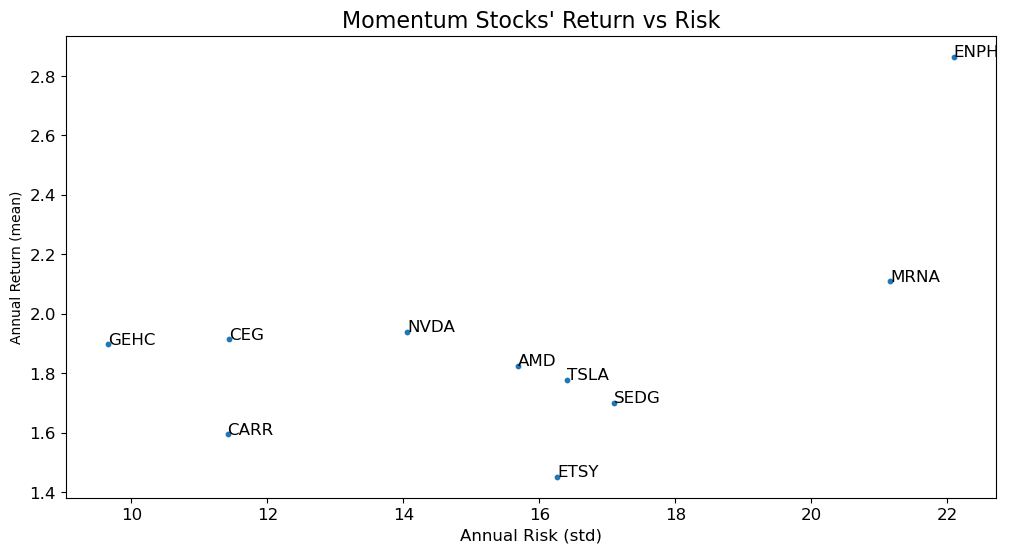

In [117]:
momentum_10.plot.scatter(x='std', y='mean', figsize=(12,6), s=10, fontsize=12)
for i in momentum_10.index:
    plt.annotate(i, xy=(momentum_10.loc[i, 'std'], momentum_10.loc[i, 'mean']), size=12)
plt.xlabel('Annual Risk (std)', fontsize=12)
plt.ylabel('Annual Return (mean)')
plt.title('Momentum Stocks\' Return vs Risk', fontsize=16)
plt.show()

## calculate Relative Strength Index (RSI) of stocks

In [118]:
change = range_stocks.diff()

In [165]:
# Create two copies of the Closing price Series
change_up = change.copy()
change_down = change.copy()

change_up[change_up<0] = 0
change_down[change_down>0] = 0

# Calculate the rolling average of average up and average down
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()

# Calculate rsi
rsi = 100 * avg_up / (avg_up + avg_down)
rsi


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,50.063385,82.213420,54.936136,65.885038,43.704674,88.060619,68.864183,49.438191,43.395867,68.446342,...,67.005812,46.229381,46.679946,52.813864,68.200140,50.196071,82.445369,53.496503,42.691623,42.817010
2023-06-27,48.765427,86.445767,56.330899,71.765904,41.205758,90.319060,71.240752,49.577483,43.193364,71.463378,...,62.479350,46.024707,44.467501,55.327866,70.151507,54.978642,84.883608,59.641929,35.956161,50.978941
2023-06-28,49.313378,86.322169,57.265454,78.390523,36.796806,94.783637,76.119391,52.832669,40.877923,75.932378,...,53.781503,34.040050,37.896376,51.285542,62.833821,59.379315,79.091319,55.014368,25.225214,62.500009


## get latest RSI of each momentum stock

In [166]:
momentum_10_tickers = list(momentum_10.index)
momentum_rsi_list = []
momentum_rsi_dict = {}
for ticker in momentum_10_tickers:
    ticker_rsi = rsi[ticker][-1]
    momentum_rsi_list.append(rsi[ticker][-1])
    momentum_rsi_dict[ticker] = ticker_rsi

momentum_rsi_dict

{'ENPH': 42.17371208512631,
 'MRNA': 46.86385821828288,
 'NVDA': 63.9274403420858,
 'CEG': 40.724955366402185,
 'GEHC': 66.8566976606058,
 'AMD': 35.66034083646273,
 'TSLA': 58.677188406795764,
 'SEDG': 42.6467327937275,
 'CARR': 85.31907576634912,
 'ETSY': 37.52352779531744}

In [167]:
# get stocks with RSI14 <= 45
orders = [ticker for ticker in momentum_rsi_dict.keys() if momentum_rsi_dict[ticker] <= 50]
orders

['ENPH', 'MRNA', 'CEG', 'AMD', 'SEDG', 'ETSY']

Text(0.5, 0, 'Date')

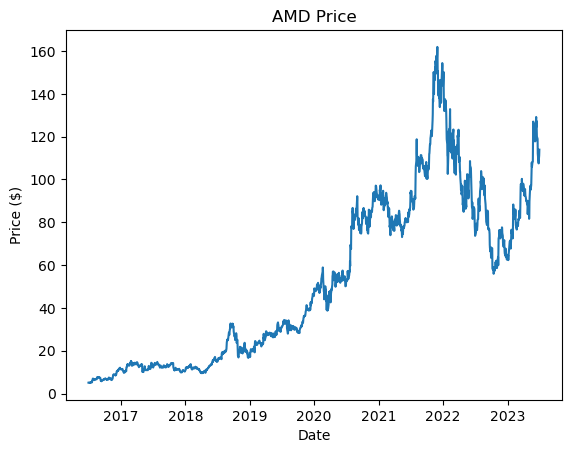

In [171]:
# plot orders' prices
order = orders[-3]
order_price = range_stocks[order]
order_rsi = rsi[order]
order_rsi.dropna()
plt.plot(stocks[order])
plt.title(order + ' Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

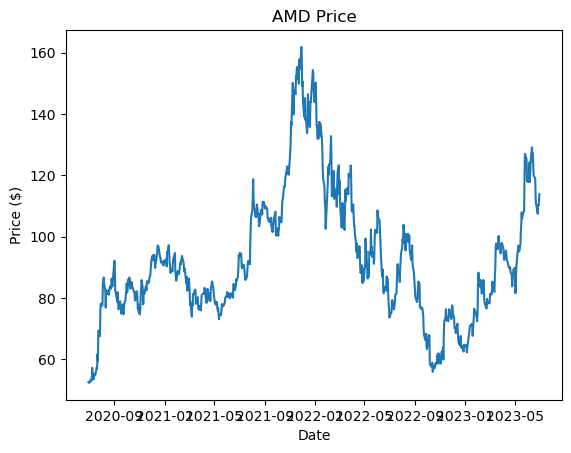

In [172]:
plt.plot(order_price)
plt.title(order + ' Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

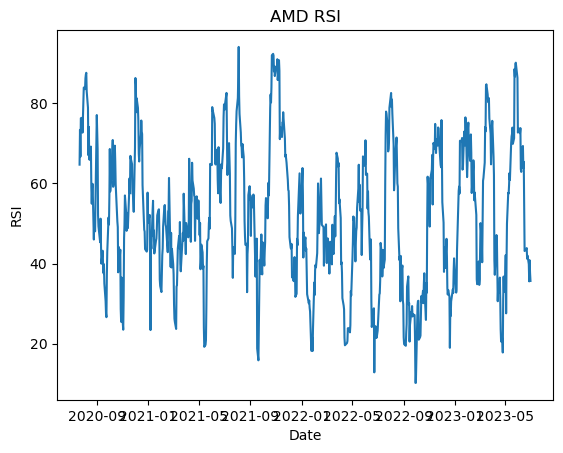

In [173]:
plt.plot(order_rsi)
plt.title(order + ' RSI')
plt.ylabel('RSI')
plt.xlabel('Date')